# Designing larger simulation data

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import random

# print directory
import os
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())

from src.models.sparse_autoencoder import *
from src.visualization.plotting import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/home/dbm829/projects/interpreting_omics_models/02_experiments/simulation
/home/dbm829/projects/interpreting_omics_models


## Generate a larger and more complex simulated dataset

In [2]:
y_dim = 20000
x_dim = 100

n_celltypes = [10, 40]
n_covariates = [1, 10]

#n_cells = 1e9 # I will subsample later
n_cells = 100

In [13]:
program_id = 0

# adjacency matrices (binary)
p_xy = 0.1
xy = torch.tensor(np.random.binomial(1, p_xy, (x_dim, y_dim))).float()
p_ctx = 0.7
cx = torch.tensor(np.random.binomial(1, p_ctx, (n_celltypes[program_id], x_dim))).float()
if n_covariates[program_id] == 1:
    cxo = torch.ones(n_covariates[program_id], x_dim)
else:
    p_cox = 0.2
    cxo = torch.tensor(np.random.binomial(1, p_cox, (n_covariates[program_id], x_dim))).float()

# distributions for the choice of categorical variables
p_ct = torch.distributions.categorical.Categorical(1/n_celltypes[program_id]*torch.ones(n_celltypes[program_id]))
p_co = torch.distributions.categorical.Categorical(1/n_covariates[program_id]*torch.ones(n_covariates[program_id]))

# sample activity is a poisson
poisson_lambda = 1.0
# get x many slightly different poisson lambdas
poisson_lambdas = torch.tensor([poisson_lambda + 0.1 * i for i in range(x_dim)])
activity_distribution = torch.distributions.poisson.Poisson(poisson_lambdas)

# distribution for sample noise
p_noise = 0.1
noise_distribution = torch.distributions.bernoulli.Bernoulli(p_noise)

###
# sampling
###

# sample activities
print('Generating ct specific activities of biological programs')
x_0 = activity_distribution.sample((n_cells,)).unsqueeze(1)
# sample cell type identities and create ct-specific activities
ct = p_ct.sample((n_cells,)) # indices of which ct to use
x_1 = x_0 * cx.unsqueeze(0)
x_1 = x_1[torch.arange(n_cells), ct]
print(x_0.shape, cx.unsqueeze(0).shape, x_1.shape)

print('Generating covariate-specific activities')
co = p_co.sample((n_cells,))
x_2 = x_1.unsqueeze(1) * cxo.unsqueeze(0)
x_2 = x_2[torch.arange(n_cells), co]
print(x_1.unsqueeze(1).shape, cxo.unsqueeze(0).shape, x_2.shape)

# create observable data
print('Generating observable data Y')
y = xy.unsqueeze(0) * x_2.unsqueeze(2)
y = y.sum(1)
print(xy.unsqueeze(0).shape, x_2.unsqueeze(2).shape, y.shape)

Generating ct specific activities of biological programs
torch.Size([100, 1, 100]) torch.Size([1, 10, 100]) torch.Size([100, 100])
Generating covariate-specific activities
torch.Size([100, 1, 100]) torch.Size([1, 1, 100]) torch.Size([100, 100])
Generating observable data Y
torch.Size([1, 100, 20000]) torch.Size([100, 100, 1]) torch.Size([100, 20000])


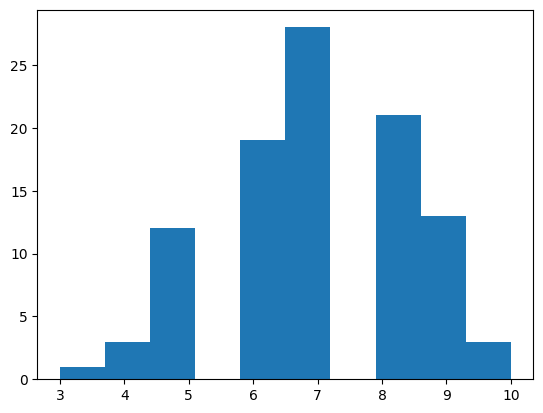

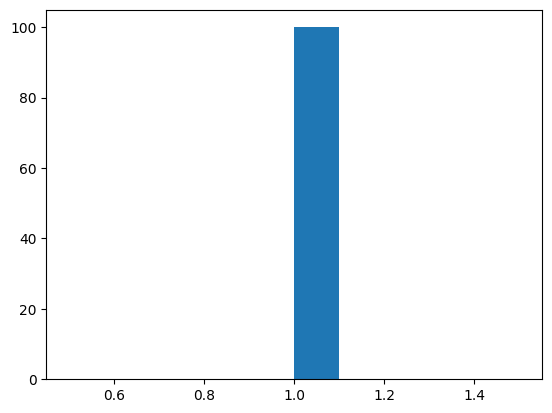

In [14]:
plt.hist(cx.sum(0))
plt.show()

plt.hist(cxo.sum(0))
plt.show()

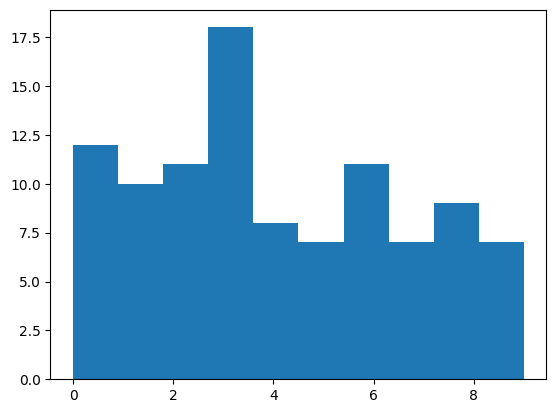

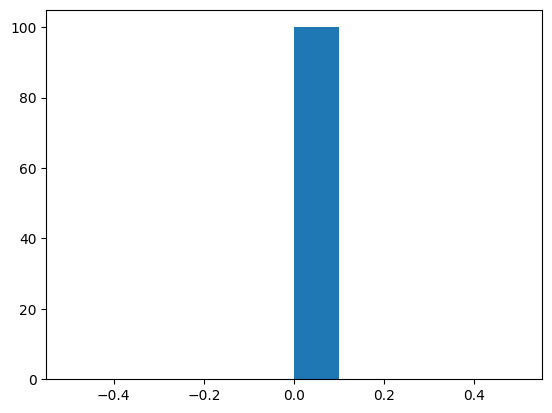

In [15]:
plt.hist(ct.flatten().numpy())
plt.show()

plt.hist(co.flatten().numpy())
plt.show()

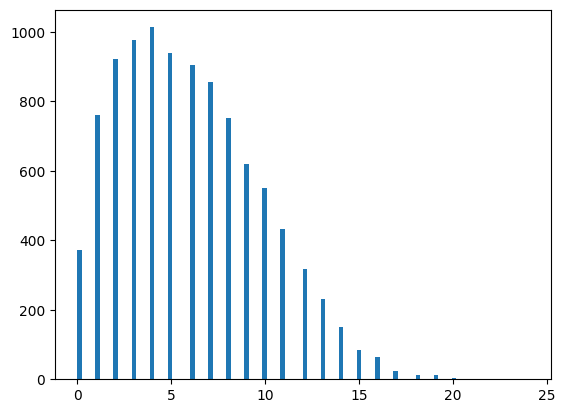

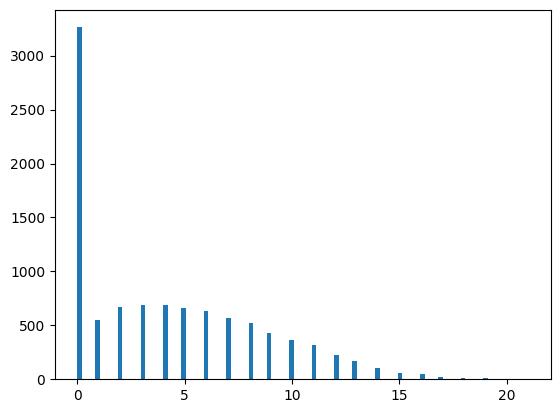

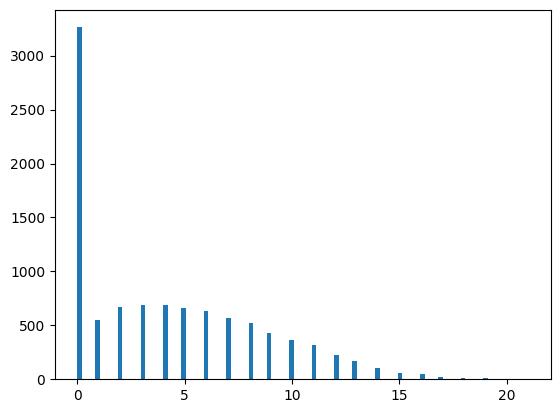

In [16]:
plt.hist(x_0.flatten().numpy(), bins=100)
plt.show()

plt.hist(x_1.flatten().numpy(), bins=100)
plt.show()

plt.hist(x_2.flatten().numpy(), bins=100)
plt.show()

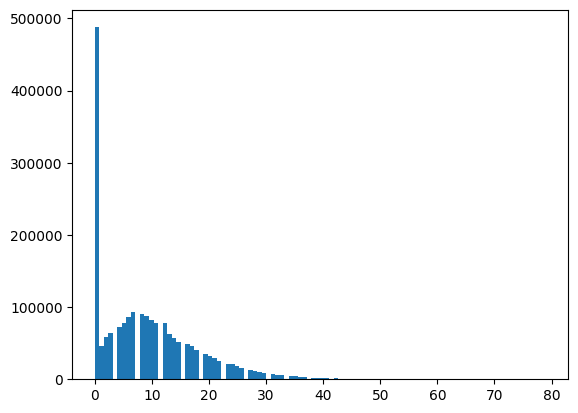

In [7]:
plt.hist(y.flatten(), bins=100)
plt.show()

In [17]:
# make a pca of x and y and color by ct

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_2.detach().numpy())
y_pca = pca.fit_transform(y.detach().numpy())

df_x = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])
df_x['ct'] = ct
df_y = pd.DataFrame(y_pca, columns=['PC1', 'PC2'])
df_y['ct'] = ct

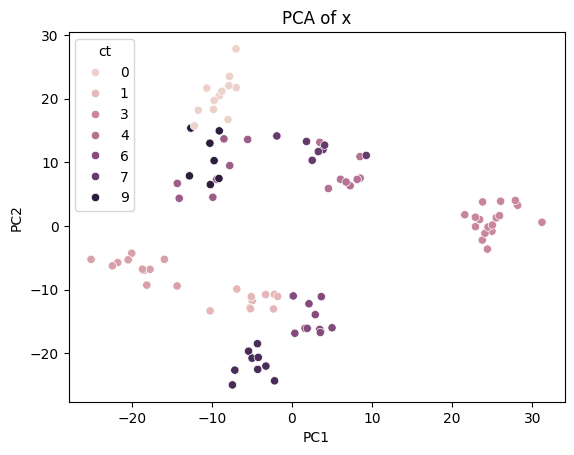

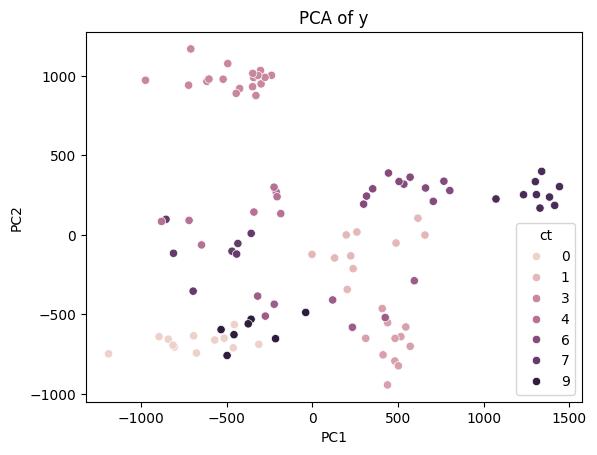

In [18]:
sns.scatterplot(data=df_x, x='PC1', y='PC2', hue='ct')
plt.title('PCA of x')
plt.show()

sns.scatterplot(data=df_y, x='PC1', y='PC2', hue='ct')
plt.title('PCA of y')
plt.show()